`Homework`

The goal of this homework is to get familiar with tools like MLflow for experiment tracking and model management.


`Q1. Install the package`

To get started with MLflow you'll need to install the appropriate Python package.

For this we recommend creating a separate Python environment, for example, you can use conda environments, and then install the package there with pip or conda.

Once you installed the package, run the command `mlflow --version` and check the output.

`What's the version that you have?`

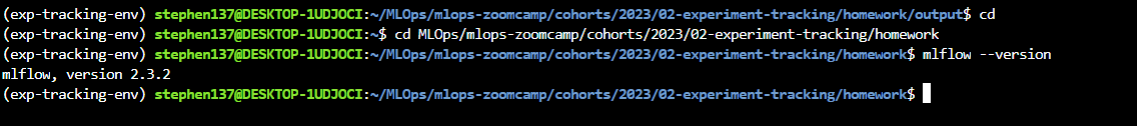

2.3.2

`Q2. Download and preprocess the data`

We'll use the `Green Taxi Trip Records` dataset to predict the amount of tips for each trip.

Download the data for `January, February and March 2022` in parquet format from [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Use the script `preprocess_data.py` located in the folder homework to preprocess the data.

The script will:

load the data from the folder <TAXI_DATA_FOLDER> (the folder where you have downloaded the data),
fit a DictVectorizer on the training set (January 2022 data),
save the preprocessed datasets and the DictVectorizer to disk.
Your task is to download the datasets and then execute this command:

`python preprocess_data.py --raw_data_path <TAXI_DATA_FOLDER> --dest_path ./output`

Tip: go to `02-experiment-tracking/homework/` folder before executing the command and change the value of `<TAXI_DATA_FOLDER>` to the location where you saved the data.

`So what's the size of the saved DictVectorizer file?`

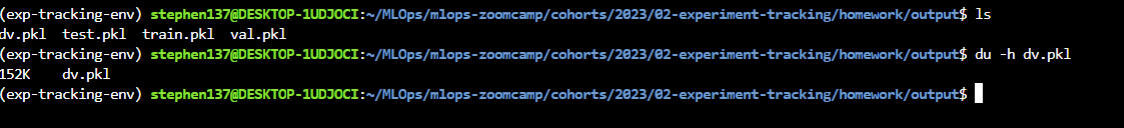


- 54 Kb
- `154 Kb` # 152 Kb so chose closest value
- 54 Mb
- 154 Mb

`Q3. Train a model with autolog`

We will train a RandomForestRegressor (from Scikit-Learn) on the taxi dataset.

We have prepared the training script `train.py` for this exercise, which can be also found in the folder homework.

The script will:

- load the datasets produced by the previous step,
- train the model on the training set,
- calculate the RMSE score on the validation set.

Your task is to `modify the script` to enable autologging with MLflow, `execute the script` and then `launch the MLflow UI` to check that the experiment run was properly tracked.

Tip 1: don't forget to wrap the training code with a with `mlflow.start_run():` statement as we showed in the videos.

Tip 2: don't modify the hyperparameters of the model to make sure that the training will finish quickly.

`train.py` - # modified

In [ ]:
import os
import pickle
import click
import mlflow # added

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mlflow.autolog() # added

def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
def run_train(data_path: str):
    
    with mlflow.start_run(): # added
        X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
        X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

        rf = RandomForestRegressor(max_depth=10, random_state=0)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred, squared=False)


if __name__ == '__main__':
    run_train()

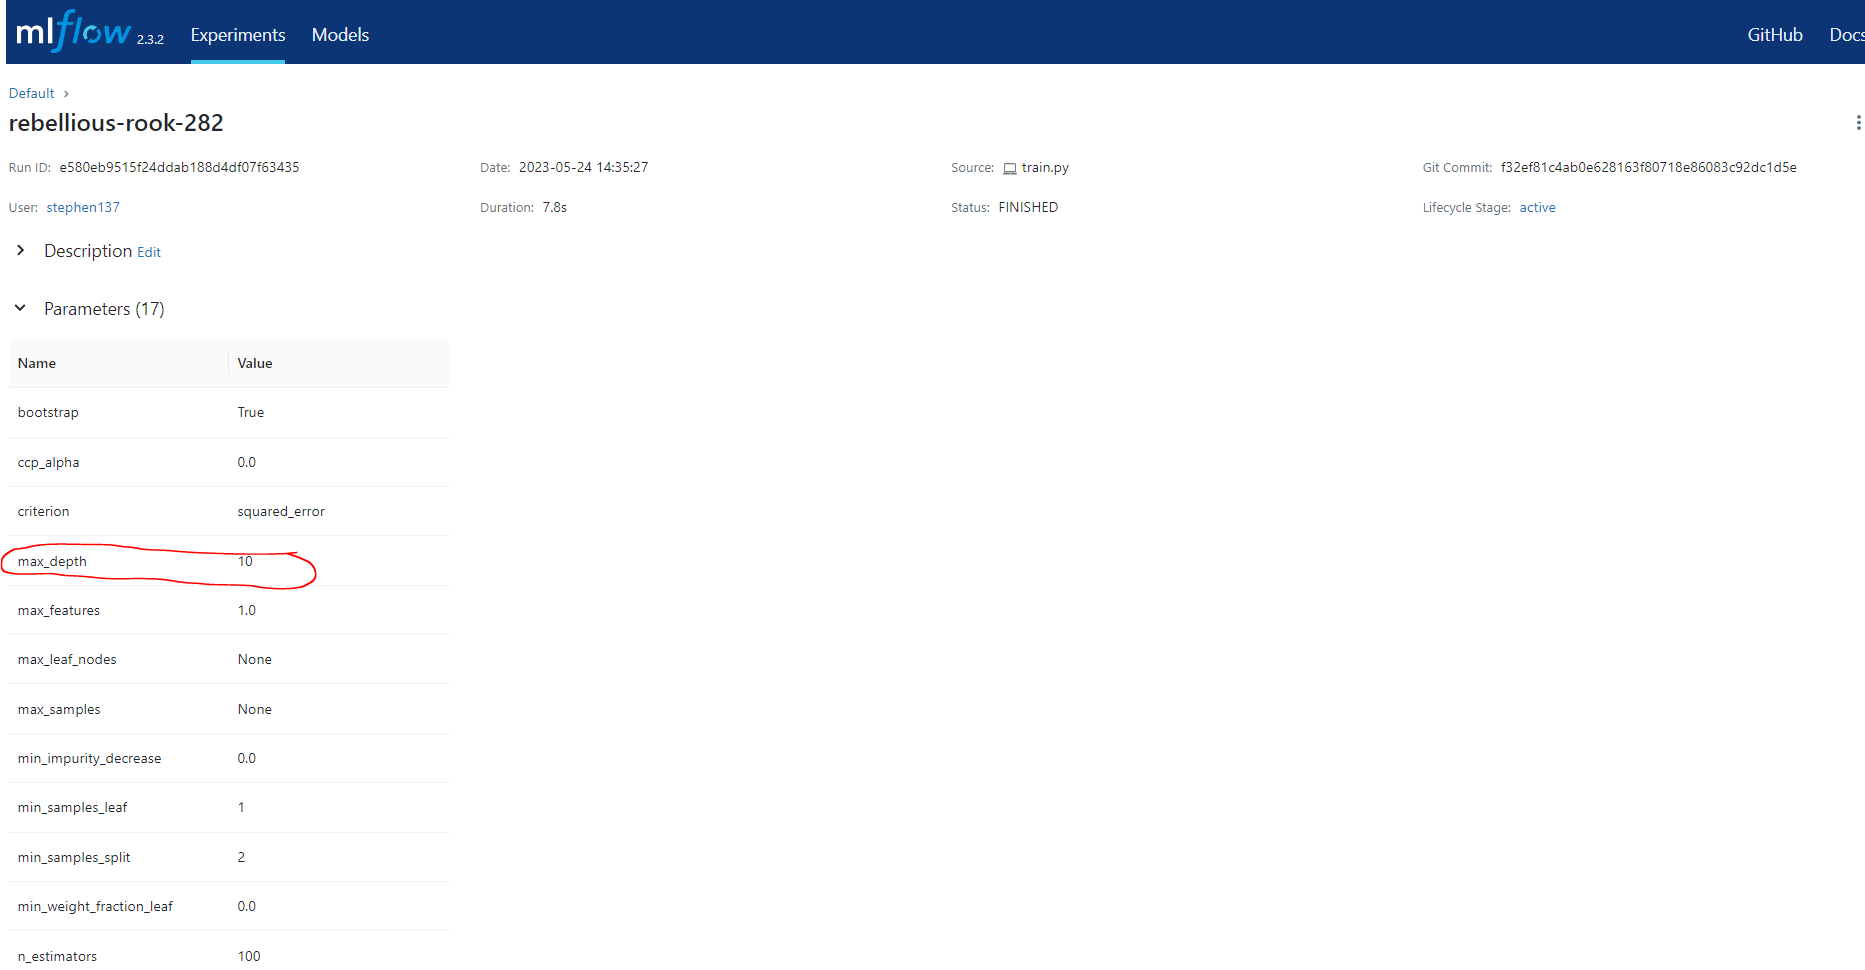

`What is the value of the max_depth parameter:`

- 4
- 6
- 8
- `10`

`Launch the tracking server locally for MLflow`
Now we want to manage the entire lifecycle of our ML model. In this step, you'll need to launch a tracking server. This way we will also have access to the model registry.

In case of MLflow, you need to:

- launch the tracking server on your local machine,
- select a SQLite db for the backend store and a folder called artifacts for the artifacts store.

You should keep the tracking server running to work on the next three exercises that use the server.

`Q4. Tune model hyperparameters`

Now let's try to reduce the validation error by tuning the hyperparameters of the RandomForestRegressor using optuna. We have prepared the script `hpo.py` for this exercise.

Your task is to **modify the script** `hpo.py` and make sure that the **validation RMSE is logged** to the tracking server for *each run of the hyperparameter optimization* (you will need to add a few lines of code to the objective function) and run the script without passing any parameters.

After that, open UI and explore the runs from the experiment called `random-forest-hyperopt` to answer the question below.

Note: Don't use autologging for this exercise.

The idea is to just log the information that you need to answer the question below, including:

- the list of hyperparameters that are passed to the objective function during the optimization,
- the RMSE obtained on the validation set (February 2022 data).

The `mlflow.start_run()` function is moved *inside* the objective function, ensuring that a new MLflow run is started for each trial.

`hpo.py` # modified

In [ ]:
import os
import pickle
import click
import mlflow
import optuna

from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://127.0.0.1:5000") 
mlflow.set_experiment("random-forest-hyperopt")

def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
@click.option(
    "--num_trials",
    default=10,
    help="The number of parameter evaluations for the optimizer to explore"
)
def run_optimization(data_path: str, num_trials: int):

    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

    def objective(trial):
        with mlflow.start_run():  # Start a new MLflow run for each trial
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 50, 1),
                'max_depth': trial.suggest_int('max_depth', 1, 20, 1),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10, 1),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4, 1),
                'random_state': 42,
                'n_jobs': -1 # automatically utilize all the processors or CPU cores available on your system
            }

                
            rf = RandomForestRegressor(**params)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)
        
            mlflow.log_params(params)  # Log the hyperparameters
            mlflow.log_metric("rmse", rmse)  # Log the validation RMSE


        return rmse

    sampler = TPESampler(seed=42)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=num_trials)


if __name__ == '__main__':
    run_optimization()

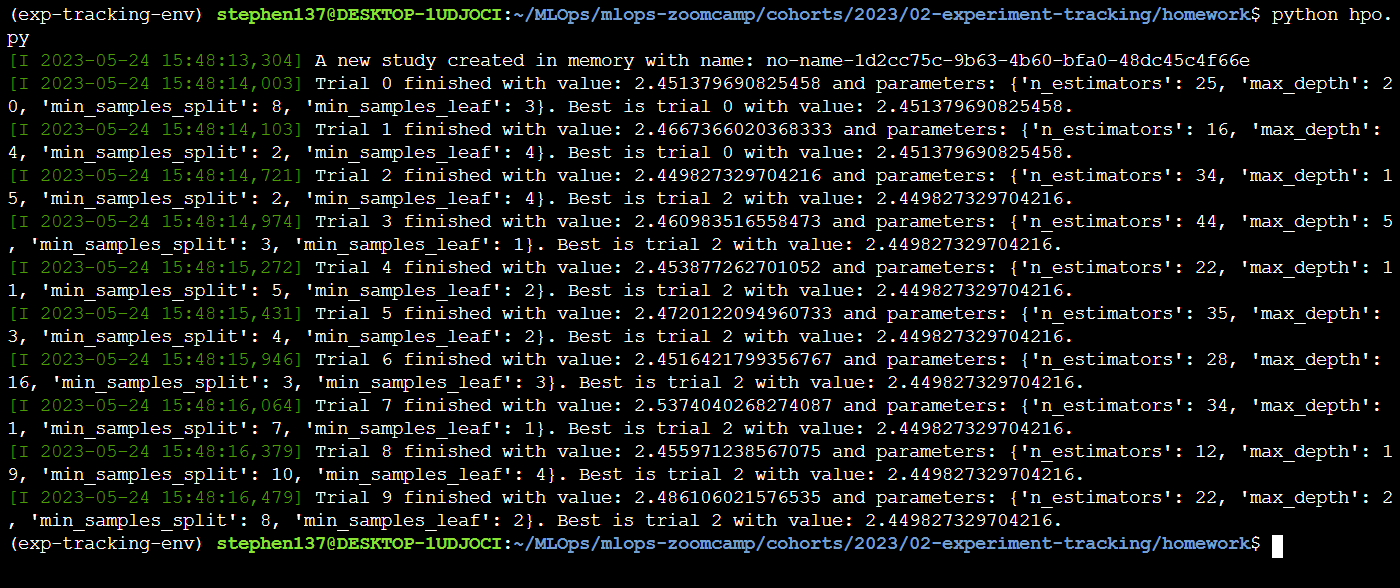

`What's the best validation RMSE that you got?`



- 1.85
- 2.15
- `2.45`
- 2.85

`Q5. Promote the best model to the model registry`

The results from the hyperparameter optimization are quite good. So, we can assume that we are ready to test some of these models in production. In this exercise, you'll promote the best model to the model registry. We have prepared a script called `register_model.py`, which will check the results from the previous step and select the top 5 runs. After that, it will calculate the RMSE of those models on the test set (March 2022 data) and save the results to a new experiment called `random-forest-best-models`.

Your task is to **update** the script `register_model.py` so that it selects the model with the lowest RMSE on the test set and registers it to the model registry.

Tips for MLflow:

- you can use the method `search_runs` from the MlflowClient to get the model with the lowest RMSE
- to register the model you can use the method `mlflow.register_model` and you will need to pass the right `model_uri` in the form of a string that looks like this: `"runs:/<RUN_ID>/model"`, and the name of the model (make sure to choose a good one!).



`register_model.py` # updated

In [ ]:
import os
import pickle
import click
import mlflow

from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
EXPERIMENT_NAME = "random-forest-best-models"
RF_PARAMS = ['max_depth', 'n_estimators', 'min_samples_split', 'min_samples_leaf', 'random_state', 'n_jobs']

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog()


def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


def train_and_log_model(data_path, params):
    X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
    X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))
    X_test, y_test = load_pickle(os.path.join(data_path, "test.pkl"))

    with mlflow.start_run():
        for param in RF_PARAMS:
            params[param] = int(params[param])

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)

        # Evaluate model on the validation and test sets
        val_rmse = mean_squared_error(y_val, rf.predict(X_val), squared=False)
        mlflow.log_metric("val_rmse", val_rmse)
        test_rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
        mlflow.log_metric("test_rmse", test_rmse)

        # Log the trained model
        mlflow.sklearn.log_model(rf, "model") #  This ensures that the model is logged and can be later registered


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
@click.option(
    "--top_n",
    default=5,
    type=int,
    help="Number of top models that need to be evaluated to decide which one to promote"
)
def run_register_model(data_path: str, top_n: int):

    client = MlflowClient()

    # Retrieve the top_n model runs and log the models
    experiment = client.get_experiment_by_name(HPO_EXPERIMENT_NAME)
    runs = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=top_n,
        order_by=["metrics.rmse ASC"]
    )
    for run in runs:
        train_and_log_model(data_path=data_path, params=run.data.params)

    # Select the model with the lowest test RMSE
    experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
    runs = client.search_runs(
        experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ALL,
        max_results=top_n,
        order_by=["metrics.test_rmse ASC"] # The test_rmse metric is used to determine the best model.
    )
    best_run = runs[0]

    # Register the best model
    model_uri = "runs:/{}/model".format(best_run.info.run_id)
    registered_model = mlflow.register_model(model_uri=model_uri, name="best_model") #

    print("Best model registered:", registered_model.name)


if __name__ == '__main__':
    run_register_model()

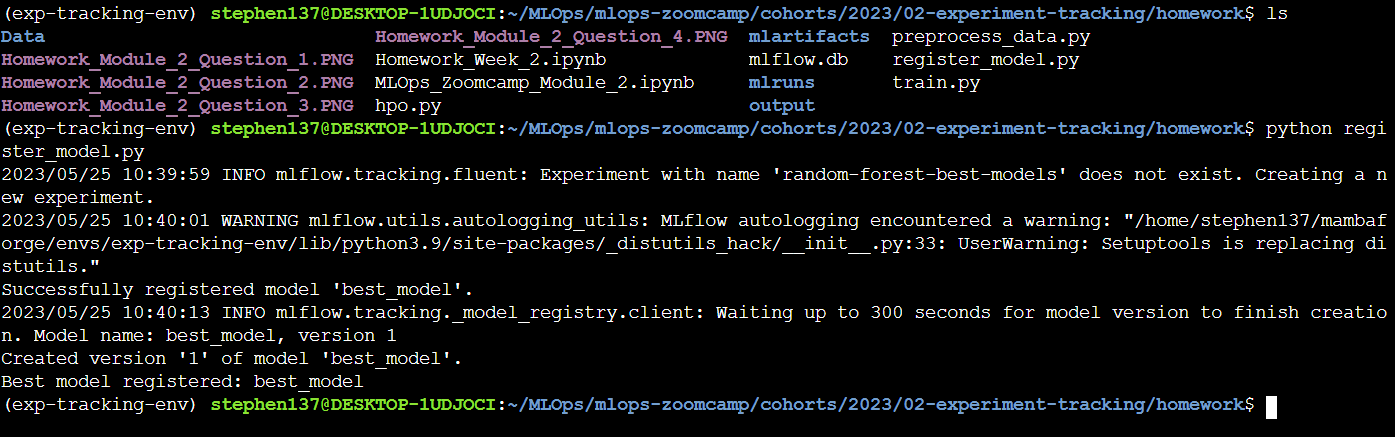

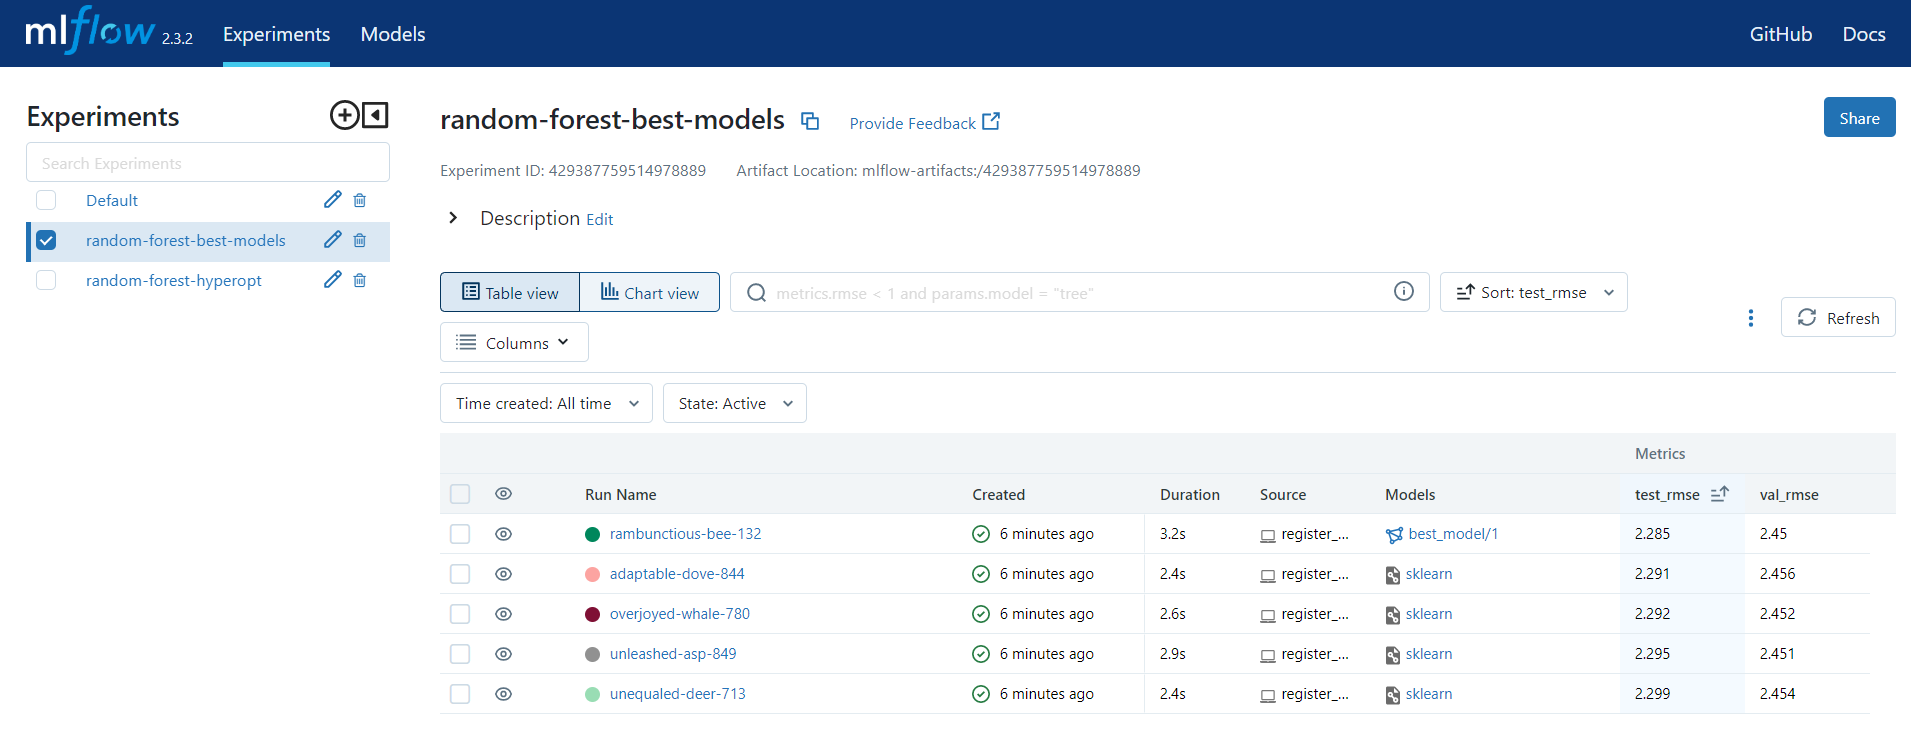

`What is the test RMSE of the best model?`

- 1.885
- `2.185` # 2.285 so chose closest value
- 2.555
- 2.955

`Q6. Model metadata`

`Now explore your best model in the model registry using UI. What information does the model registry contain about each model?`

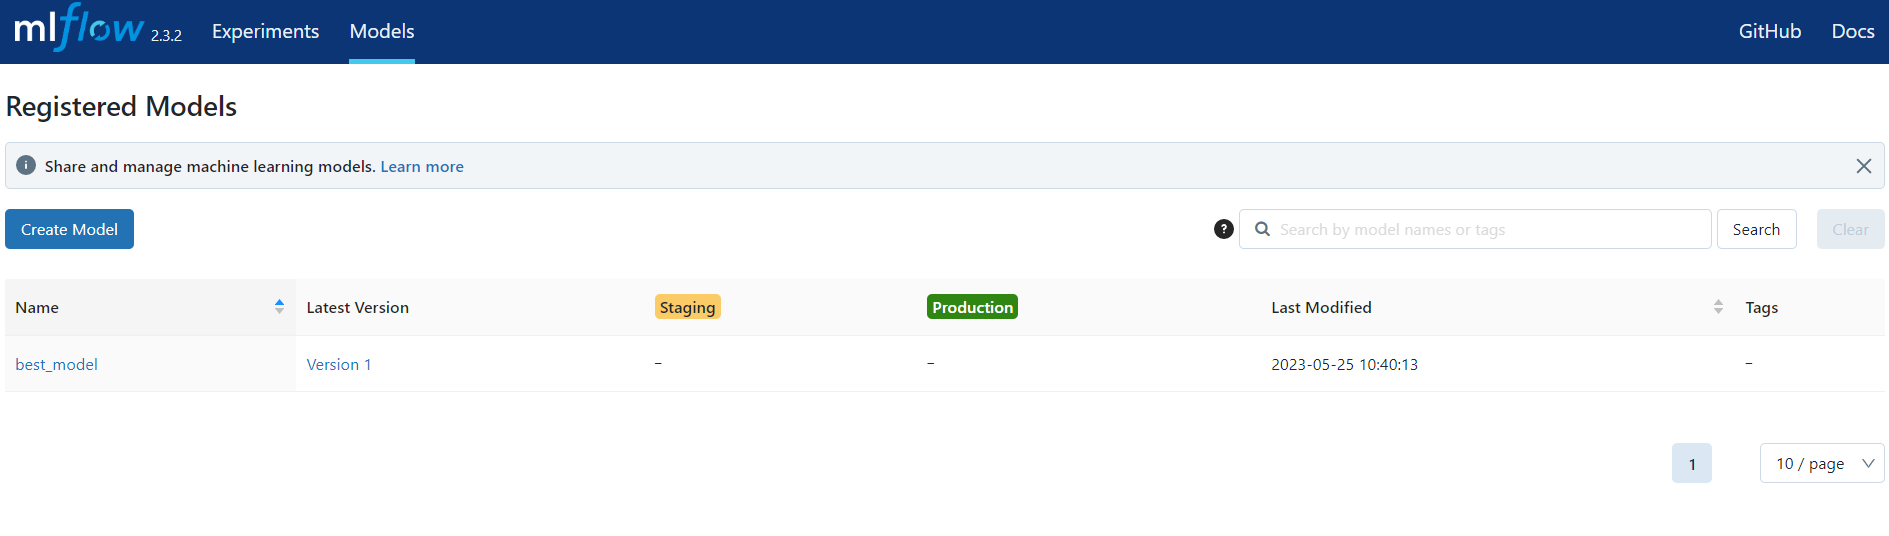


- `Version number`
- Source experiment
- Model signature
- All the above answers are correct



`Submit the results`\
Submit your results here: coming soon
You can submit your solution multiple times. In this case, only the last submission will be used
If your answer doesn't match options exactly, select the closest one

`Deadline`\
The deadline for submitting is 1 June 2023 (Thursday), 23:00 CEST (Berlin time).

After that, the form will be closed.